In [65]:
### importing packages ###
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl
from tqdm import tqdm
import math

### 1. Defining the models as a functions

This model is essentially the same one I used in the practicals, I just added some more comments throughout.

In [15]:
### ICE SHEET MODEL ###

def ice_model(dt, time_total,                  #time increment [years], total time of the model run [years]
             dx, x_total,                      #spatial increment [m], total length of the ice sheet [m]
             e=10**(-4),                       #setting minimum ice thickness [m] (these are the automatic values that will be used if not explicitly specified)
             rho=917,                          #ice density [kg/m^3]
             g=9.8,                            #acceleration due to gravity [m/s^2]
             A=24*(10**(-25))*60*60*24*365.4,  #flow law parameter [Pa a]
             n=3):                             #flow law exponent

    #setup grids & empty thickness array to fill 
    time = np.arange(0, time_total, dt)
    x    = np.arange(0, x_total, dx)
    H    = np.zeros((len(time), len(x))) #H[time, x]
    
    #surface mass balance
    b_i = 10**(-4) * ((x_total/3) - x)
    
    #ice thickness simulation
    for timestep in tqdm(np.arange(1,len(time))): #tqdm displays progress bar for loop

        # save the old thickness vector
        H_old  = H[timestep-1,:]

        # (1) compute H on the staggered grid
        H_stag = (H_old[1:] + H_old[:-1])/2

        # (2) compute the surface slope on the staggered grid.
        alpha = -(H_old[1:] - H_old[:-1])/dx 

        # (3) compute the flux on the staggered grid
        q = 2*A/(n+2) * (rho * g * alpha)**n * H_stag**(n+2)  

        # (4) compute the ice thickness at the current time step
        h_test = dt * (b_i[1:-1] - ((q[1:]-q[:-1])/dx)) + H_old[1:-1]
        h_test[h_test<0] = e 
        H[timestep, 1:-1] = h_test


        # apply the boundary conditions at x = 0 and x = X
        H[timestep,0] = H[timestep,1]
        H[timestep,-1] = e
        
    return x, time, H, q #the q is just the final flux
    

Really quickly I want to make sure the function is working correctly:

In [49]:
x, time, H, q = ice_model(2/365, 5000, 200, 40000)

100%|██████████| 912499/912499 [00:42<00:00, 21405.18it/s]


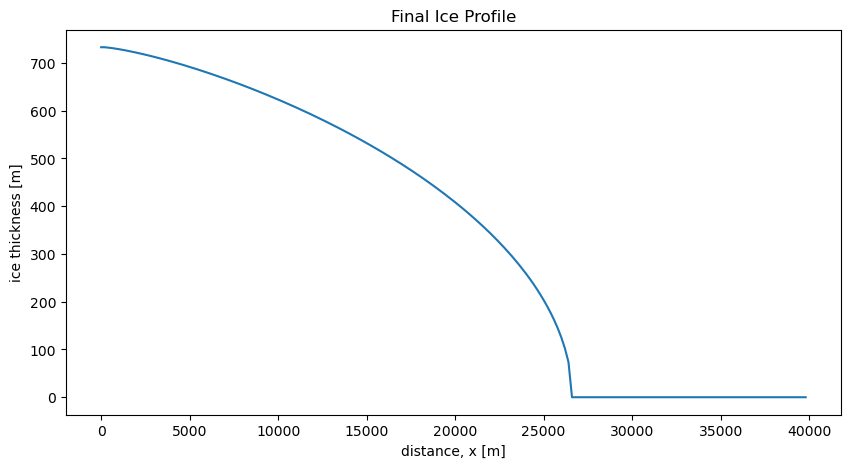

In [50]:
#plotting up the results for the final thickness
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, H[-1, :])
ax.set_xlabel('distance, x [m]')
ax.set_ylabel('ice thickness [m]')
ax.set_title('Final Ice Profile');

Looking good to me! Now I can move on to the heat flow model.

In [5]:
### HEAT FLOW MODEL ###

def heat_model(dt, time_total, #time increment [years], total time of the model run [years]
              dz, z_total,     #spatial increment [m], total height of the ice sheet [m]
              a_yr=0.1,        #accumulation [m/year]            
              T_surf = -20     #surface temperature [deg. C]
              ):        
    
    #constants
    seconds_per_year = 3.154 * 10**7 #seconds/year
    alpha            = 1.25e-6       #thermal diffusivity [k/rho_i/c]
    G                = 60e-3         #geothermal heat flux [mW/m^2]        
    k                = 2.3           #Thermal conductivity of ice at -10C [W/mK]
 
    #time grid
    dt_inseconds         = dt*seconds_per_year;        #converting dt to seconds
    time_total_inseconds = time_total*seconds_per_year #converting total time to seconds
    t = np.linspace(0,time_total_inseconds,round(time_total_inseconds/dt_inseconds))  #time grid [sec.]
    
    #space grid
    z = np.linspace(0,z_total,round(z_total/dz))  #spatial grid [m]
    
    #vertical ice velocity
    a = a_yr/seconds_per_year        #accumulation [m/second]
    w = -np.linspace(0,a,np.size(z)) #vertical velocity, sign convention is that up is positive, and we are assuming it varies from zero at the bed to a at the surface
    
    #temperature grid
    T = np.zeros((np.size(t),np.size(z))) #empty array to to fill as the model evolves [time, depth]
    
    #initial conditions
    T[0,:] = np.linspace(0,T_surf,np.size(z)) #intitial temp. profile
    
    ##TEMPERATURE SIMULATION##
    for timestep in tqdm(np.arange(1,len(t))): #tqdm displays progress bar for loop

        T[timestep,1:-1] = T[timestep-1,1:-1] + dt_inseconds * ( alpha *   ( T[timestep-1,2:]-2*T[timestep-1,1:-1]+T[timestep-1,:-2])/dz**2 - w[1:-1]*(T[timestep-1,2:]-T[timestep-1,:-2])/(2*dz) )   

        #boundary conditions
        T[timestep,-1] = T_surf;
        T[timestep,0] = T[timestep,1] + (G/k*dz)  
        
    return T, z       

Now I'll test the temperature model. I'll plot the final temperature profiles for a range of ice thicknesses.

100%|██████████| 29999/29999 [00:00<00:00, 45930.86it/s]


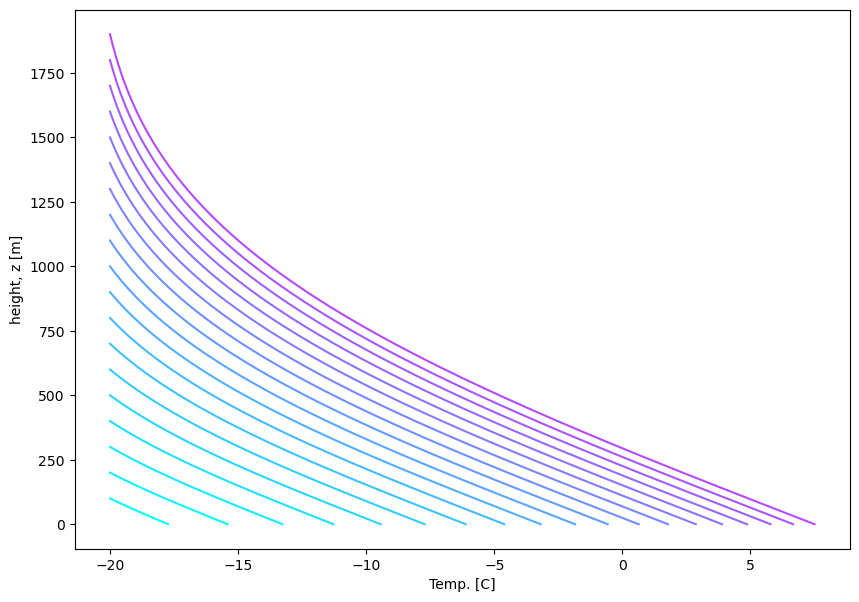

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel('Temp. [C]')
ax.set_ylabel('height, z [m]')
new_cmap = cm.get_cmap('cool', 128)
counter  = 0

for i in np.arange(0.1, 2, 0.1):
    T, z = heat_model(1, 30000, 10, i*1000)
    ax.plot(T[-1,:],z, color=new_cmap(counter))
    counter += 5

Okay, now I can look into the the model's sensitivity to reaching steasy state.

## 2. some exploring

Plotting thickness at ice divide over time of simulation. I'll use the results from the simulation I ran in the first part.

In [113]:
icedivide_thick = []
icedivide_time  = [] 
change = []

for i in np.arange(0, len(time), 5000):
    change_bystep   = H[i+1, 0] - H[i, 0]
    change = np.append(change, change_bystep)
    icedivide_thick = np.append(icedivide_thick, H[i, 0])
    icedivide_time  = np.append(icedivide_time, time[i]) 
    

In [108]:
y = np.exp(((-icedivide_time)/100))

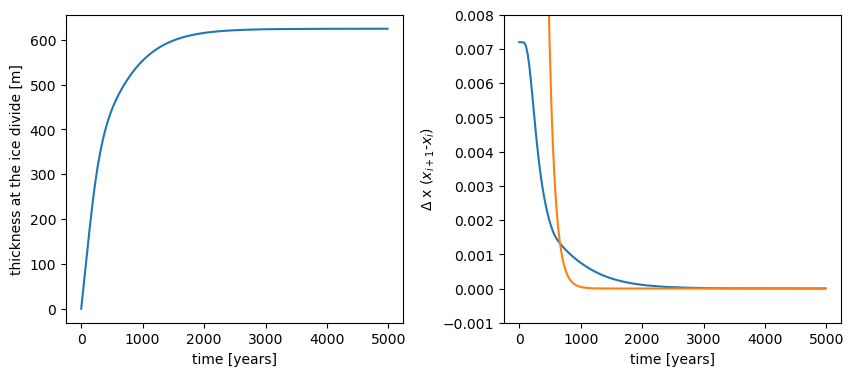

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3)

axs[0].plot(icedivide_time, icedivide_thick)
axs[0].set_xlabel('time [years]')
axs[0].set_ylabel('thickness at the ice divide [m]')

axs[1].plot(icedivide_time, change)
axs[1].plot(icedivide_time, y)
axs[1].set_ylim([-0.001,0.008])
axs[1].set_xlabel('time [years]')
axs[1].set_ylabel('\u0394 x ($x_{i+1}$-$x_{i}$)');

Now I'm gonna take a first look into how A will effect these curves^.

In [219]:
##collecting the data##

#parameters for model
Amax    = 4 * (24*10**(-25)*60*60*24*365.4) #setting upper limit of A, value in parentheses is the 'typical' A value
A_range = np.arange(0, Amax, Amax/10)       #making array of A values from zero to Amax
dt      = 2/365                             #2 day length time step
time_tot= 5000                              #total time [years]
dx      = 200                               #spatial step
x_tot   = 40000                             #total length of ice sheet [m]

#stuff for plotting evolution
t           = np.arange(0, time_tot, dt)
evolution   = np.arange(0, len(t), 10000)
del_x       = np.zeros((len(A_range), len(evolution)))
icedivide   = np.zeros((len(A_range), len(evolution)))
short_time  = np.zeros((len(A_range), len(evolution)))
efold_times = []

for i in range(0, len(A_range)):
    
    #running the model
    print('Run',i+1,'/',len(A_range),', A =', A_range[i], ':')        #progress statement
    x, time, H, qs = ice_model(dt, time_tot, dx, x_tot, A=A_range[i])
    
    #measuring evolution
    icedivide_thick = []
    icedivide_time  = [] 
    change = []
    
    for j in evolution:
        
        change_bystep   = H[j+1, 0] - H[j, 0]
        change          = np.append(change, change_bystep)
        icedivide_thick = np.append(icedivide_thick, H[j, 0])
        icedivide_time  = np.append(icedivide_time, time[j]) 
    
    if i != 0:  
        dex         = H[1:, 0]-H[:-1, 0]
        difference  = np.absolute(dex-efold)
        index       = difference.argmin()
        efold_times = np.append(efold_times, time[index])
    
    del_x[i, :]      = change
    icedivide[i, :]  = icedivide_thick
    short_time[i, :] = icedivide_time

Run 1 / 10 , A = 0.0 :


100%|██████████| 912499/912499 [00:40<00:00, 22303.17it/s]


Run 2 / 10 , A = 3.03077376e-17 :


100%|██████████| 912499/912499 [00:41<00:00, 21922.05it/s]


Run 3 / 10 , A = 6.06154752e-17 :


100%|██████████| 912499/912499 [00:43<00:00, 21051.38it/s]


Run 4 / 10 , A = 9.09232128e-17 :


100%|██████████| 912499/912499 [00:41<00:00, 21955.53it/s]


Run 5 / 10 , A = 1.212309504e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 21955.28it/s]


Run 6 / 10 , A = 1.5153868800000002e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 21782.67it/s]


Run 7 / 10 , A = 1.818464256e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 21835.15it/s]


Run 8 / 10 , A = 2.121541632e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 21964.66it/s]


Run 9 / 10 , A = 2.424619008e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 21985.14it/s]


Run 10 / 10 , A = 2.7276963840000003e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 21979.55it/s]


In [220]:
efold_times

array([355.14520548, 325.66575342, 309.57260274, 298.63561644,
       290.42191781, 283.87945205, 278.46027397, 273.85205479,
       269.85205479])

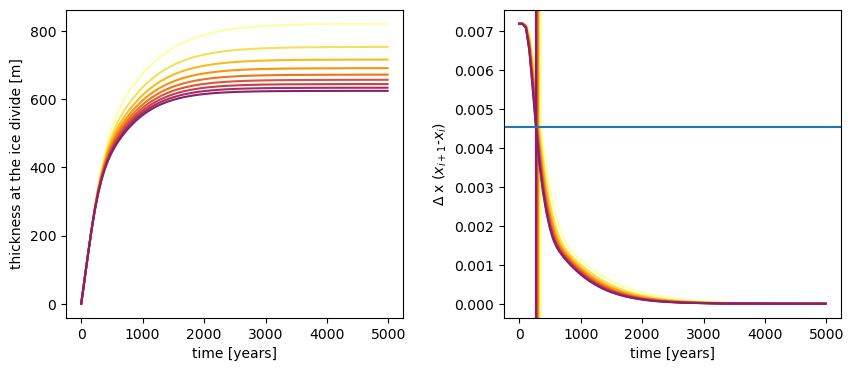

In [222]:
#setting up the figure
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3)

axs[0].set_xlabel('time [years]')
axs[0].set_ylabel('thickness at the ice divide [m]')
#axs[0].set_xlim([0,10])
#axs[0].set_ylim([0,2])

axs[1].set_xlabel('time [years]')
axs[1].set_ylabel('\u0394 x ($x_{i+1}$-$x_{i}$)')

new_cmap = cm.get_cmap('inferno_r', 128) #making color map object to use for distiguishing various A values 

#plotting
counter = 0
for i in range(1, len(A_range)):
    axs[0].plot(short_time[i, :], icedivide[i, :], color=new_cmap(counter))
    axs[1].plot(short_time[i, :], del_x[i, :], color=new_cmap(counter))
    if i!=0:
        axs[1].axvline(x=efold_times[i-1], color=new_cmap(counter))
    counter += 10


axs[1].axhline(y=efold)

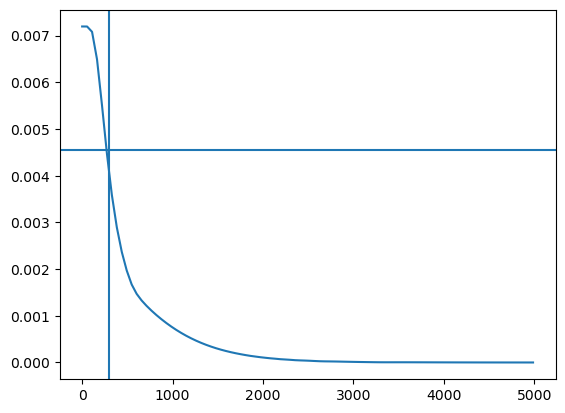

In [204]:
fig, ax = plt.subplots()
ax.plot(icedivide_time, change)
ax.axhline(y=efold)
ax.axvline(x=300)

In [205]:
difference

array([2.64738812e-03, 2.64672656e-03, 2.53263697e-03, 1.94468332e-03,
       9.66759410e-04, 7.44135519e-05, 9.62298873e-04, 1.65473089e-03,
       2.18070618e-03, 2.57914588e-03, 2.87866428e-03, 3.07880500e-03,
       3.21996543e-03, 3.33585814e-03, 3.43911124e-03, 3.53407177e-03,
       3.62222495e-03, 3.70427937e-03, 3.78045838e-03, 3.85101432e-03,
       3.91613103e-03, 3.97617888e-03, 4.03122344e-03, 4.08165052e-03,
       4.12775235e-03, 4.16982743e-03, 4.20789166e-03, 4.24271041e-03,
       4.27394399e-03, 4.30227121e-03, 4.32791981e-03, 4.35098823e-03,
       4.37174063e-03, 4.39071351e-03, 4.40790068e-03, 4.42230536e-03,
       4.43632602e-03, 4.44819412e-03, 4.45935238e-03, 4.46828046e-03,
       4.47838597e-03, 4.48476142e-03, 4.49159398e-03, 4.49951248e-03,
       4.50421605e-03, 4.50777909e-03, 4.51224430e-03, 4.51746008e-03,
       4.52228790e-03, 4.52475230e-03, 4.52604998e-03, 4.52764866e-03,
       4.52973584e-03, 4.53201748e-03, 4.53424832e-03, 4.53630360e-03,
      

In [191]:
efold_times

array([0.03287671, 0.03287671, 0.03287671, 0.02739726, 0.02739726,
       0.02739726, 0.02739726, 0.02739726, 0.02739726])

In [ ]:
efold = del_x[0, :][0] - (del_x[0, :][0]/math.exp(1)) #x_i - (x_i/e)

In [187]:
efold

0.004548958907368982

In [183]:
efold_times = []
for i in range(0, len(A_range)):
    del_x_choose = del_x[i, :]
    print(i)
    for j in range(0, len(evolution)):
        
        if (del_x_choose[j] <= efold):
            efold_times = np.append(efold_times, short_time[i, j])
            break

0
1
2
3
4
5
6
7
8
9


In [181]:
efold_times

array([383.56164384, 328.76712329, 328.76712329, 328.76712329,
       328.76712329, 328.76712329, 328.76712329, 273.97260274,
       273.97260274])

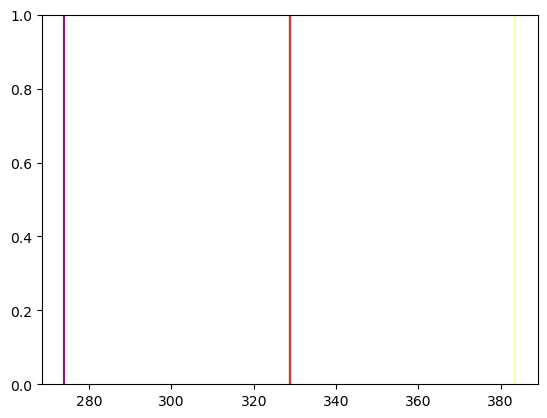

In [186]:
fig, ax = plt.subplots()

#plotting
counter = 0
for i in range(1, len(A_range)):
    #ax.plot(short_time[i, :], del_x[i, :], color=new_cmap(counter))
    ax.axvline(x=efold_times[i-1], color=new_cmap(counter))
    counter += 10
    
